# 1. Stylization

### Importing modules to load, transform the image, and send prediction requests to the API

In [1]:
import cv2
import requests
import numpy as np
import matplotlib.pyplot as plt

### Global Variables

In [2]:
STYLE_MODEL_IMAGE_SHAPE = (256, 256, 3)

# this assumes you're serving multiple models behind the same host:port
# if you're using serve_stylization_model.sh and serve_super_resolution_model.sh instead, use port 8502 here
PREDICTION_ENDPOINT_STYLE = "http://localhost:8501/v1/models/stylization:predict"

### Helper functions

In [3]:
def read_image_from_url(url: str) -> np.ndarray:
    """
    Reads an image from a URL
    and returns it as an OpenCV BGR image

    Args:
        url (str) : url of the image

    Returns:
       np.ndarray: A cv2 COLOR image, BGR
    """
    # the user agent header is there to make wikipedia think the request occured from an iphone, it'll forbid the request otherwise
    # you can set this to any human-used browser btw
    response = requests.get(
        url,
        headers={
            "User-Agent": "Mozilla/5.0 (iPad; U; CPU OS 3_2_1 like Mac OS X; en-us) AppleWebKit/531.21.10 (KHTML, like Gecko) Mobile/7B405"
        },
    )
    img = cv2.imdecode(np.frombuffer(response.content, np.uint8), cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img


def preprocess_style_image(image: np.ndarray, KERNEL_SIZE=(7, 7)) -> np.ndarray:
    """
    A simple blur applied to the style image as a preprocessing step,
    also resizes the image to the model's input shape

    Args:
        image (np.ndarray) : A cv2 COLOR image, BGR
        KERNEL_SIZE (tuple) : The kernel size of the average pooling operation

    Returns:
       np.ndarray: A cv2 COLOR image, BGR
    """

    kernel = np.ones(KERNEL_SIZE, np.float32) / (KERNEL_SIZE[0] * KERNEL_SIZE[1])
    dst = cv2.filter2D(image, -1, kernel)

    # since the model expects a square image, let's try not to distort the image by resizing a non square image to a square one directly
    # and crop it insted, some features will be lost, but the assumption is that the style remains consistent throughout the image, so a
    # little cropping won't make a difference

    smallest_dimenstion = min(image.shape[:2])
    squared = dst[:smallest_dimenstion, :smallest_dimenstion]
    final_image = cv2.resize(squared, STYLE_MODEL_IMAGE_SHAPE[:2])
    return final_image


def convert_to_float(image: np.ndarray) -> np.ndarray:
    """
    Converts the uint8 image to float32 image compatible with the model's input
    Args:
        image (np.ndarray) : A cv2 COLOR image, BGR, uint8

    Returns:
       np.ndarray: A cv2 COLOR image, BGR, float32
    """
    image_final = image.astype(np.float32) / 255.0
    return image_final

#### Loading and preprocessing our images 

In [4]:
ref_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0d/Black_Snub-nosed_Monkey_(44489823001).jpg/1200px-Black_Snub-nosed_Monkey_(44489823001).jpg"
style_image_url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Abraham_Teniers_-_Barbershop_with_monkeys_and_cats.jpg/1024px-Abraham_Teniers_-_Barbershop_with_monkeys_and_cats.jpg"

ref_image = read_image_from_url(ref_image_url)
style_image = read_image_from_url(style_image_url)
final_ref_image = convert_to_float(ref_image)
preprocessed_style_image = preprocess_style_image(style_image)
final_style_image = convert_to_float(preprocess_style_image(preprocessed_style_image))

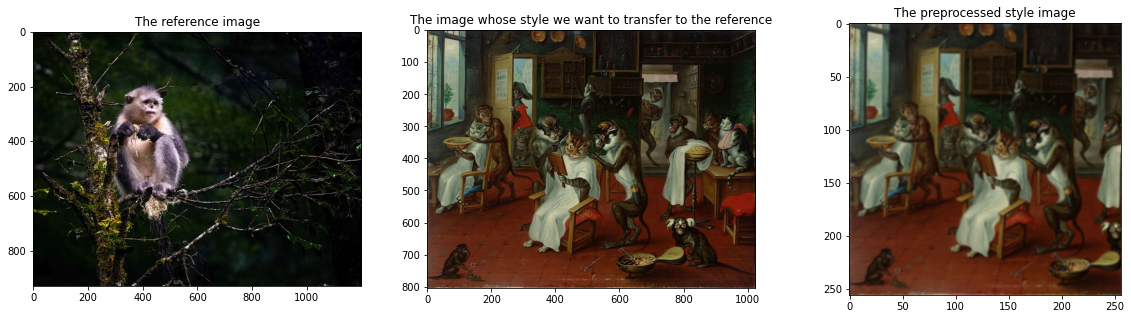

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
axs[0].imshow(ref_image)
axs[0].set_title("The reference image")

axs[1].imshow(style_image)
axs[1].set_title("The image whose style we want to transfer to the reference")

axs[2].imshow(preprocessed_style_image)
axs[2].set_title("The preprocessed style image")
plt.show()

### Transferring the style via our API

In [6]:
resp = requests.post(
    PREDICTION_ENDPOINT_STYLE,
    json={
        "instances": [
            {
                "placeholder": final_ref_image.tolist(),
                "placeholder_1": final_style_image.tolist(),
            }
        ]
    },
)

# For this particular model, the output image is in the [0] index of the prediction
output_img = np.array(resp.json()["predictions"][0])

### Moment of Truth! Let's see how the style transfer worked!

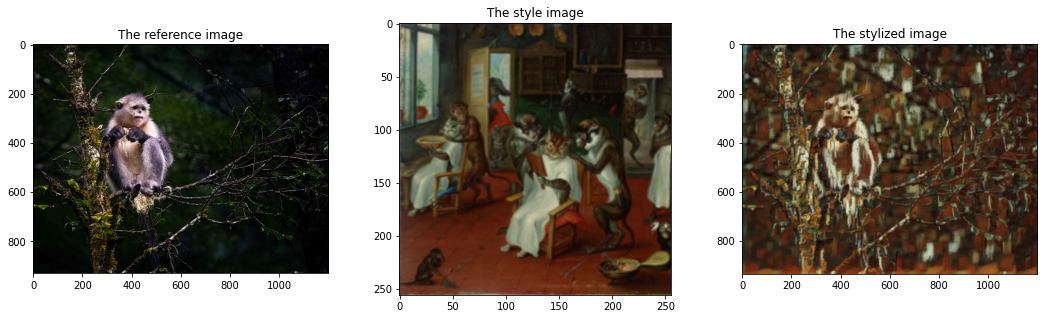

In [7]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
axs[0].imshow(ref_image)
axs[0].set_title("The reference image")

axs[1].imshow(preprocessed_style_image)
axs[1].set_title("The style image")

axs[2].imshow(output_img)
axs[2].set_title("The stylized image")

plt.show()

Works pretty swimmingly, as expected!

# 2. Super Resolution (Enhancement)

### Global Variables

In [8]:
PREDICTION_ENDPOINT_SUPER_RESOLUTION = (
    "http://localhost:8501/v1/models/super_resolution:predict"
)

### Helper functions

In [9]:
def preprocess_image(image: np.ndarray) -> np.ndarray:
    """
    Resizes the image to the model's input type
    Args:
        image (np.ndarray) : A cv2 COLOR image, BGR

    Returns:
       np.ndarray: a 4D numpy float32 array, compatible with the model's input
    """
    image_float = image.astype(np.float32)
    final_img = np.expand_dims(image_float, axis=0)
    return final_img

### We'll use a lower quality version of the output of the previous section as the input image

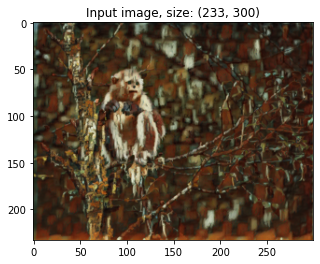

In [10]:
original_image = output_img.copy()
original_image_shape = original_image.shape[:2]

# purposefully making the image a lower (1/4th) size and changing the type to uint8 so the pixel values fall in the 0-255 range (as accepted by the model)

input_image = (
    cv2.resize(
        original_image,
        (original_image_shape[1] // 4, original_image_shape[0] // 4),
        cv2.INTER_CUBIC,
    )
    * 255
).astype("uint8")

plt.imshow(input_image)
plt.title("Input image, size: {}".format(input_image.shape[:2]))
plt.show()

### Preprocessing the image, to make it model-ready, and sending the prediction request to the API

In [11]:
preprocessed_image = preprocess_image(input_image)

In [12]:
resp = requests.post(
    PREDICTION_ENDPOINT_SUPER_RESOLUTION,
    json={
        "instances": preprocessed_image.tolist(),
    },
)
output_image = np.array(resp.json()["predictions"][0]).astype("uint8")

### Let's see the result!

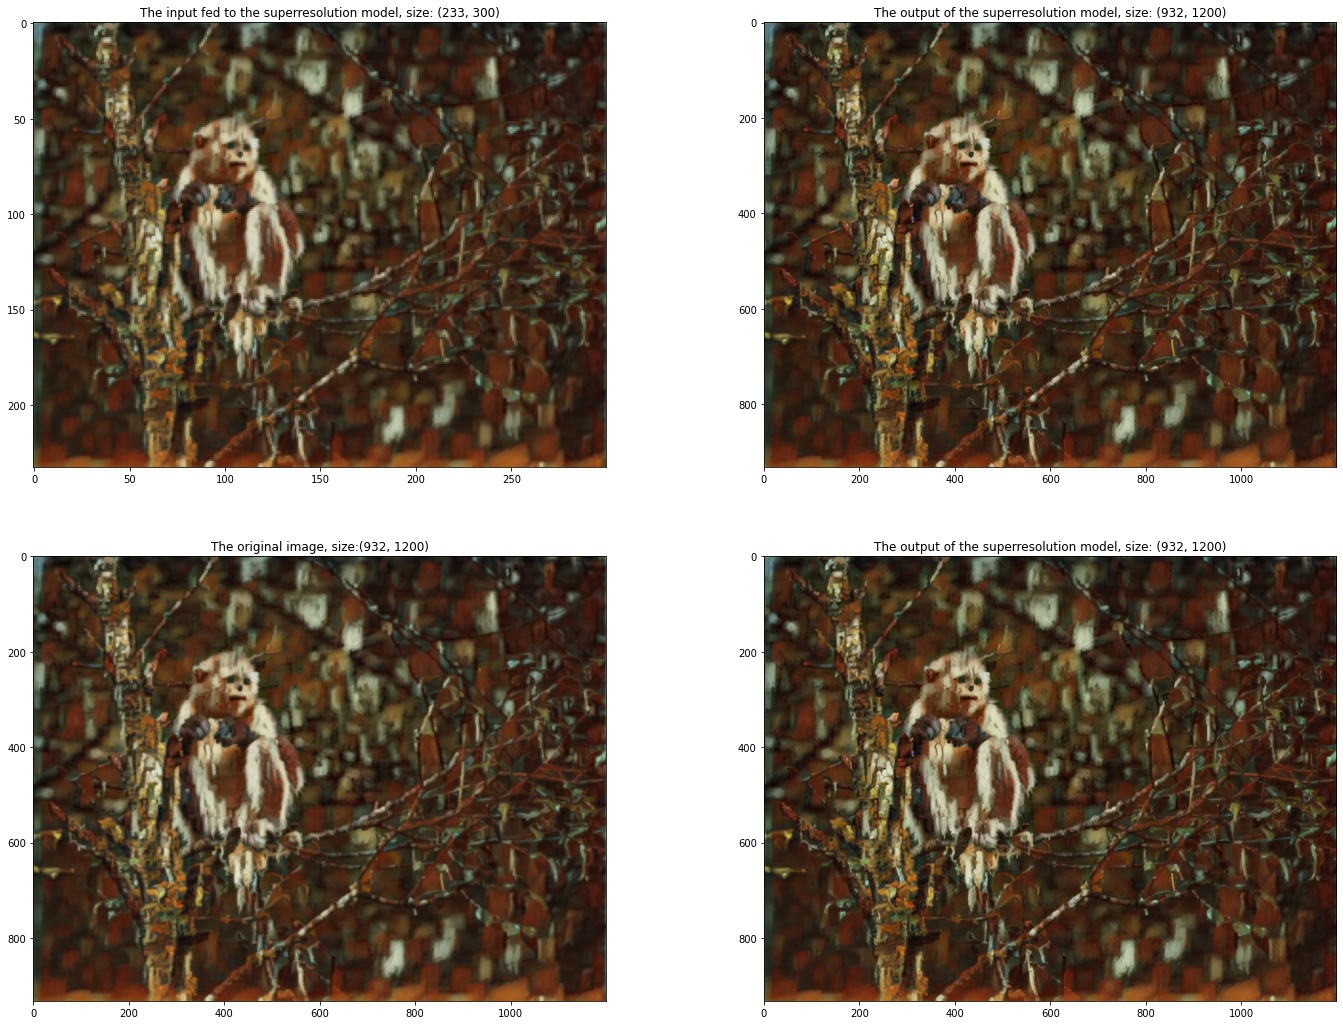

In [13]:
output_image = np.clip(
    output_image, 0, 255
)  # a postprocessing step as specified by the superresolution reference paper

fig, axs = plt.subplots(2, 2, figsize=(24, 18))

axs[0][0].imshow(input_image)
axs[0][0].set_title(
    f"The input fed to the superresolution model, size: {input_image.shape[:2]}"
)

axs[0][1].imshow(output_image)
axs[0][1].set_title(
    f"The output of the superresolution model, size: {output_image.shape[:2]}"
)

axs[1][0].imshow(original_image)
axs[1][0].set_title(f"The original image, size:{original_image.shape[:2]}")

axs[1][1].imshow(output_image)
axs[1][1].set_title(
    f"The output of the superresolution model, size: {output_image.shape[:2]}"
)

plt.show()

Is it just me, or does the super resolution version look better than the original?